In [98]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, Flatten, Dense

### Load Data

In [99]:
df = pd.read_csv('08067600_LakeConroe.csv')
df.columns = ['date', 'storage', 'precip', 'temperature']
df['date'] = pd.to_datetime(df['date'])

### EDA

In [100]:
print(df.describe())


             storage       precip  temperature
count    4138.000000  4138.000000  4138.000000
mean   392385.206154     0.137164    68.383723
std     33996.033382     0.444534    14.172748
min       -51.470000     0.000000    14.859177
25%    376979.600000     0.000000    57.830395
50%    402062.610000     0.000064    70.892791
75%    415978.202000     0.057179    80.982318
max    484319.580000     9.840724    90.790719


In [101]:
print(df.isnull().sum())

date           0
storage        0
precip         0
temperature    0
dtype: int64


### View Trends - Data Visualization

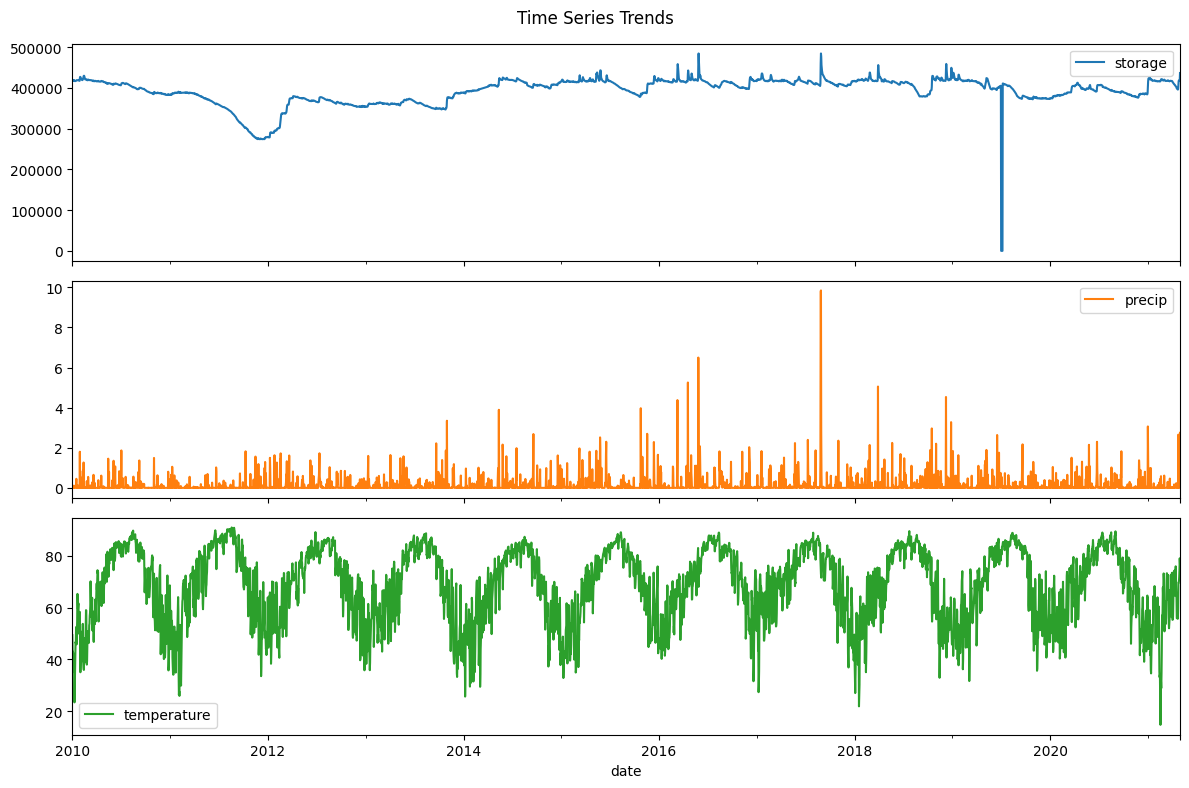

In [102]:
df.set_index('date')[['storage', 'precip', 'temperature']].plot(subplots=True, figsize=(12, 8), title='Time Series Trends')
plt.tight_layout()
plt.show()

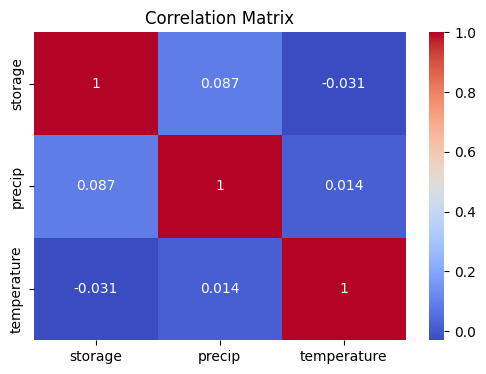

In [103]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[['storage', 'precip', 'temperature']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Model

In [104]:
# Feature Engineering
df = df.sort_values('date')
df['precip_lag1'] = df['precip'].shift(1)
df['temperature_lag1'] = df['temperature'].shift(1)
df['storage_lag1'] = df['storage'].shift(1)
df.dropna(inplace=True)

In [105]:
# Define features and target
features = ['precip', 'temperature', 'precip_lag1', 'temperature_lag1', 'storage_lag1']
target = 'storage'

In [106]:
# Split train/test
train_df = df[df['date'] <= '2021-04-20']
test_df = df[df['date'] > '2021-04-20']

X_train = train_df[features].values
y_train = train_df[target].values
X_test = test_df[features].values
y_test = test_df[target].values

In [107]:
# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [108]:
# Train Models
## Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

In [109]:
# CNN Model
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

cnn_model = Sequential([
    InputLayer(input_shape=(X_train_cnn.shape[1], 1)),
    Conv1D(32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=16, verbose=0)

y_pred_cnn = cnn_model.predict(X_test_cnn).flatten()

/Users/duthie/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [110]:
#Evaluation
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [111]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%\n")

In [112]:
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("CNN", y_test, y_pred_cnn)

Linear Regression Performance:
  MAE:  3146.75
  RMSE: 4489.70
  MAPE: 0.75%

CNN Performance:
  MAE:  7881.50
  RMSE: 13281.22
  MAPE: 1.88%



### Data Visualization - Predictions

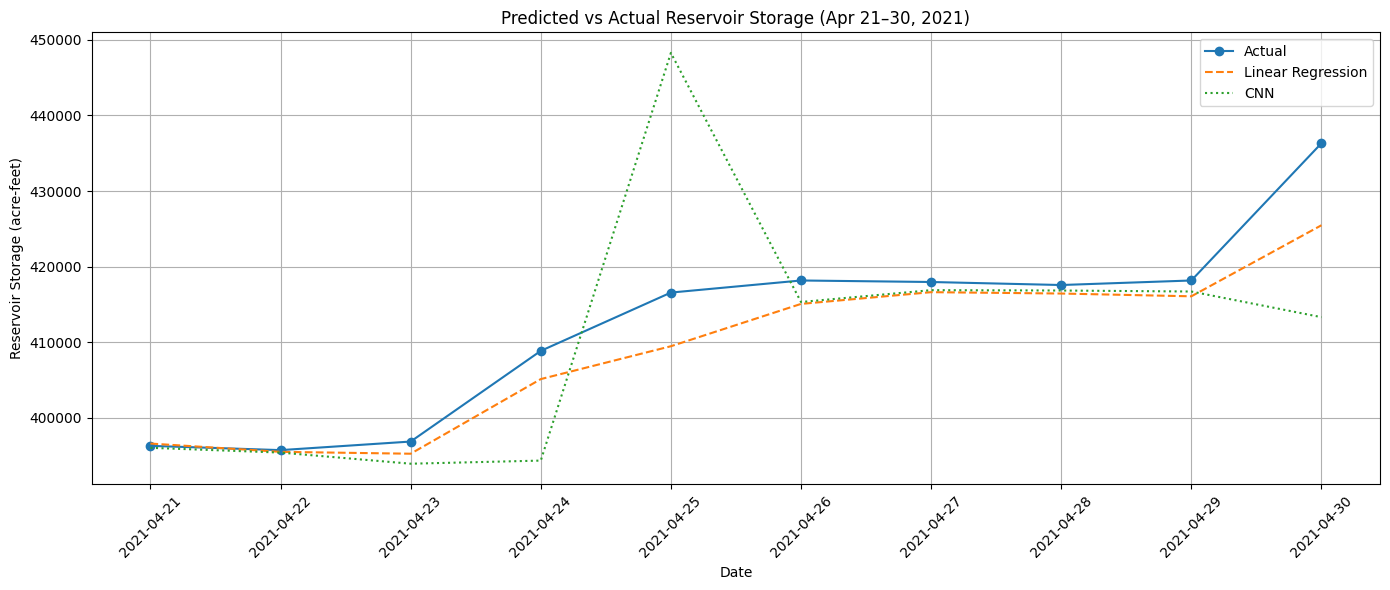

In [113]:
# Plot Predictions
plt.figure(figsize=(14, 6))
plt.plot(test_df['date'], y_test, label='Actual', marker='o')
plt.plot(test_df['date'], y_pred_lr, label='Linear Regression', linestyle='--')
plt.plot(test_df['date'], y_pred_cnn, label='CNN', linestyle=':')
plt.title('Predicted vs Actual Reservoir Storage (Apr 21–30, 2021)')
plt.xlabel('Date')
plt.ylabel('Reservoir Storage (acre-feet)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()